# Imports

In [ ]:
!pip3 install -q tf-models-nightly
# Fix Colab default opencv problem
!pip3 install -q opencv-python-headless==4.1.2.30

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

tf.keras.utils.set_random_seed(0)

In [ ]:
concat_features = tfm.uplift.layers.encoders.concat_features
two_tower_logits_head = tfm.uplift.layers.heads.two_tower_logits_head
two_tower_uplift_network = tfm.uplift.layers.uplift_networks.two_tower_uplift_network
two_tower_uplift_model = tfm.uplift.models.two_tower_uplift_model
true_logits_loss = tfm.uplift.losses.true_logits_loss
treatment_fraction = tfm.uplift.metrics.treatment_fraction
uplift_mean = tfm.uplift.metrics.uplift_mean
label_mean = tfm.uplift.metrics.label_mean

# Introduction

Uplift modeling is a crucial research area focused on estimating the causal influence of a treatment on an individual's behavior. It predicts how a customer's actions differ with and without the treatment. Within digital advertising for example, this treatment might involve exposure to various ads. Uplift modeling can then optimize marketing efforts by targeting users who demonstrate the most significant potential return on investment. This approach is essential because customers exhibit varied responses to treatments:

- *persuadables*: these individuals consistently react positively to marketing, mostly purchasing only when exposed to the treatment
- *do not disturbs*: this group has a strongly negative reaction to marketing; they are likely to purchase if left untreated
- *lost causes*: these customers won't purchase regardless of marketing efforts, making spending ineffective
- *sure things*: these consumers will purchase irrespective of marketing, eliminating the need for targeted spending

Therefore, uplift modeling aims to pinpoint the *persuadables*, conserve resources by avoiding *sure things* and *lost causes*, and prevent negative experiences for the *do not disturbs*.



# Dataset

This colab walks through a very simple overview of how to use the uplift modeling library to build, train and evaluate an uplift model on large scale data. The dataset used in this colab is Criteo's uplift prediction [dataset](https://ailab.criteo.com/criteo-uplift-prediction-dataset/). This dataset is constructed by assembling data resulting from several incrementality tests, a particular randomized trial procedure where a random part of the population is prevented from being targeted by advertising.

The data is collected such that at a pre-defined moment, users are randomly assigned to either a treated or control group. Before this assignment, user features (mainly related to prior activity) are collected. After assignment, the treated group receives personalized advertising while the control group does not. Ad visits and online conversions are logged for two weeks following assignment. Finally, the initial user features, treatment status, ad exposure, visits, and conversions are combined for analysis. Note that it is possible for a user in the treatment group to never get exposed to the treatment, which is indicated by the "exposure" feature. Nevertheless, we will ignore this feature in this analysis in order to keep the validity of the randomized control trial setting and to ensure that the uplift $u(x)$ is calculated by the difference of the following conditional expectations:


$$u(x) = \mathbb{E}[Y | T=1, X=x] - \mathbb{E}[Y | T=0, X=x]$$


The dataset consists of 14M rows, each one representing a user with eleven features, a treatment indicator and two possible labels (visits and conversions). The data fields are as follows:

- f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11: anonymized feature values
- treatment: treatment group (0 = control, 1 = treatment)
- visit: whether a visit occured for this user (0 = did not visit, 1 = visited)
- conversion: whether a conversion occured for this user (0 = did not purchase, 1 = purchased)
- exposure: whether the user was exposed to a treatment during the experiment (0 = not exposed, 1 = exposed)

A more comprehensive introduction to the Criteo dataset can be found in their accompanying papers [[1](https://hal.science/hal-02515860v1/document)] and [[2](https://arxiv.org/pdf/2111.10106.pdf)].

In [ ]:
# Load dataset (all of the data is stored under the "train" split).
full_dataset = tfds.load("criteo")["train"]
full_dataset = full_dataset.shuffle(
    buffer_size=10_000,
    seed=0,
    reshuffle_each_iteration=False,
)
print(f"Number of datapoints: {full_dataset.cardinality().numpy()}")

Number of datapoints: 13979592


In [ ]:
# Use 1M examples for testing and keep the rest for training.
N_TEST = 1_000_000

test_dataset = full_dataset.take(N_TEST)
train_dataset = full_dataset.skip(N_TEST)

print(f"Number of train datapoints: {train_dataset.cardinality().numpy()}")
print(f"Number of test datapoints:  {test_dataset.cardinality().numpy()}")

Number of train datapoints: 12979592
Number of test datapoints:  1000000


In [ ]:
# Take a small sample for exploratory data analysis.
sample_df = tfds.as_dataframe(train_dataset.take(10_000))
sample_df.head(10)

,conversion,exposure,f0,f1,f10,f11,f2,f3,f4,f5,f6,f7,f8,f9,treatment,visit
0,False,False,26.003653,10.059654,5.300375,-0.168679,8.214383,4.679882,10.280525,4.115453,-5.987667,4.833815,3.971858,13.190056,1,False
1,False,False,19.585320,10.679513,5.300375,-0.168679,8.217696,1.114982,10.280525,3.013064,-10.527786,8.367581,3.809904,42.775658,1,True
2,False,False,12.616364,10.059654,5.300375,-0.168679,8.261647,4.679882,10.280525,4.115453,0.294443,4.833815,3.906514,25.240993,1,False
3,False,False,24.760006,10.059654,5.300375,-0.168679,8.214383,4.679882,10.280525,4.115453,-4.595459,4.833815,3.971858,13.190056,1,False
4,False,False,23.326521,10.059654,5.300375,-0.168679,8.214383,4.679882,10.280525,4.115453,-7.301017,4.833815,3.971858,13.190056,1,False
5,False,False,16.174679,10.059654,5.300375,-0.168679,8.425407,2.934780,10.280525,4.115453,-3.282109,4.833815,3.869313,29.214161,1,True
6,False,False,20.825842,10.059654,5.300375,-0.168679,8.214383,4.679882,10.280525,3.013064,-1.288207,8.996727,3.971858,13.190056,1,False
7,False,False,21.404404,10.059654,6.425741,-0.168679,8.800342,4.679882,11.029585,4.115453,-7.301017,4.833815,3.899112,13.190056,1,False
8,False,False,24.595268,10.059654,5.300375,-0.168679,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,1,False
9,False,False,22.833614,10.059654,5.300375,-0.168679,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,1,False


In [ ]:
sample_df[["visit", "conversion"]] = sample_df[["visit", "conversion"]].astype(int)
sample_df.describe()

,conversion,f0,f1,f10,f11,f2,f3,f4,f5,f6,f7,f8,f9,treatment,visit
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.00250,19.599846,10.069551,5.332988,-0.171190,8.448245,4.177443,10.338730,4.031238,-4.131609,5.097363,3.932956,16.088783,0.849700,0.046800
std,0.04994,5.362421,0.094223,0.167144,0.024777,0.299626,1.336848,0.340552,0.412840,4.535934,1.191975,0.057004,7.101997,0.357383,0.211221
min,0.00000,12.616364,10.059654,5.300375,-0.827690,8.214383,-5.106985,10.280525,-2.404006,-23.423904,4.833815,3.682439,13.190056,0.000000,0.000000
25%,0.00000,12.616364,10.059654,5.300375,-0.168679,8.214383,4.679882,10.280525,4.115453,-6.699321,4.833815,3.910792,13.190056,1.000000,0.000000
50%,0.00000,21.919387,10.059654,5.300375,-0.168679,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,1.000000,0.000000
75%,0.00000,24.411213,10.059654,5.300375,-0.168679,8.732892,4.679882,10.280525,4.115453,0.294443,4.833815,3.971858,13.190056,1.000000,0.000000
max,1.00000,26.745085,12.520096,6.473310,-0.168679,9.051891,4.679882,16.369278,4.115453,0.294443,11.991045,3.971858,57.158524,1.000000,1.000000


In [ ]:
print(f"Treatment fraction: {sample_df.treatment.mean()}")

Treatment fraction: 0.8497


The data is highly imbalanced since 85% of the examples belong to the treatment group. This does not necessarily pose a problem for uplift modeling though, as we will discuss in greater detail in the next section.

In [ ]:
print(f"Average visit rate: {sample_df.visit.mean()}")
print(f"Average conversion rate: {sample_df.conversion.mean()}")

Average visit rate: 0.0468
Average conversion rate: 0.0025


The conversion rate is significantly lower than the visit rate, providing a sparser and therefore more challenging dataset for model training. Since a conversion follows from a visit, in this analysis we will focus on predicting the likelihood of visit occuring and leave the conversion estimation to a later stage.

In [ ]:
ctrl_visit_rate = sample_df[sample_df.treatment == 0].visit.mean() * 100
trmt_visit_rate = sample_df[sample_df.treatment == 1].visit.mean() * 100
visit_rate = sample_df.visit.mean() * 100

print(f"Visit rate (overall):     {visit_rate:.2f}%")
print(f"Visit rate (control):     {ctrl_visit_rate:.2f}%")
print(f"Visit rate (treatment):   {trmt_visit_rate:.2f}%")
print(f"Average treatment effect: {trmt_visit_rate - ctrl_visit_rate:.2f}%")

Visit rate (overall):     4.68%
Visit rate (control):     3.53%
Visit rate (treatment):   4.88%
Average treatment effect: 1.36%


As expected, the treatment group has a higher visit rate (4.88%) than the control group (3.53%). The average treatment effect (1.36%) suggests that the treatment is effective at increasing the visit rate, and is a good starting point for uplift modeling. An uplift model is typically used to identify the set of users whose likelihood of visiting increases the most when exposed to the treatment.

# Randomized Control Trial Test

Randomized controlled trials are considered the gold standard for estimating causal effects because they help mitigate two major threats to drawing causal conclusions from data: confounding and selection bias. The randomization balances out the distribution of confounding variables across the control and treatment groups, which helps isolate the true treatment effect.

Since uplift models aim to predict the difference in outcome between receiving a treatment and not receiving it, if the data is biased the model might learn patterns that do not reflect the true impact of the treatment. We can test if the data is truly random by training a classifier to predict whether an example belongs to the treatment group from its feature set. In a randomized control trial setting it should not be possible for a model to predict if an example belongs to the treatment group or not.

In [ ]:
FEATURE_NAMES = [f"f{i}" for i in range(12)]
TREATMENT_NAME = "treatment"

def preprocess(inputs: dict[str, tf.Tensor]) -> tuple[tf.Tensor, tf.Tensor]:
  features = tf.stack([inputs[name] for name in FEATURE_NAMES], axis=-1)
  label = inputs[TREATMENT_NAME]
  return features, label

class Classifier(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self._mlp = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1)
    ])

  def call(self, inputs: tf.Tensor) -> tf.Tensor:
    return self._mlp(inputs)

classifier = Classifier()
classifier.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.AUC(curve="ROC", from_logits=True),
    ]
)

classifier.fit(
    train_dataset.map(preprocess).batch(1024),
    validation_data=test_dataset.map(preprocess).batch(1024),
    epochs=3,
);

Epoch 1/3
12676/12676 [==============================] - 203s 15ms/step - loss: 0.4236 - binary_accuracy: 0.8499 - auc: 0.5059 - val_loss: 0.4224 - val_binary_accuracy: 0.8502 - val_auc: 0.5096
Epoch 2/3
12676/12676 [==============================] - 155s 11ms/step - loss: 0.4228 - binary_accuracy: 0.8500 - auc: 0.5070 - val_loss: 0.4223 - val_binary_accuracy: 0.8502 - val_auc: 0.5097
Epoch 3/3
12676/12676 [==============================] - 141s 10ms/step - loss: 0.4227 - binary_accuracy: 0.8500 - auc: 0.5073 - val_loss: 0.4222 - val_binary_accuracy: 0.8502 - val_auc: 0.5099


The AUC value on the test split is indeed 0.5, indicating that the model cannot distinguish between examples in the control and treatment group and therefore does no better than random guessing. This validates the randomized control trial setting and ensures we have unbiased data that is perfect for uplift modeling!

# Uplift Modeling

The initial release of the uplift modeling library focuses on the family of models that follow the two tower uplift network architecture illustrated below. The library is written in Keras and is designed in a modular, layered manner such that it can easily be extended with custom layers and components. We offer a suite of tools (losses, metrics etc.) that can be hooked up with any Keras-compatible training framework (like Keras' training [API](https://keras.io/api/models/model_training_apis/), [Orbit](https://www.tensorflow.org/tfmodels/orbit) and [TFRS](https://www.tensorflow.org/recommenders)) in order to train an uplift model on potentially billions of datapoints.

The two tower uplift model is composed of the following components:
- Inputs: a mapping from feature names to feature tensors. The tensors can be of different types, eg `tf.Tensor`, `tf.SparseTensor` and `tf.RaggedTensor`.
- Backbone: a trainable network that computes an embedding from the inputs shared between the control and treatment arms.
- Control and treatment feature encoders: trainable networks that compute embeddings from control and treatment speficic features.
- Control and treatment feature combiners: methods to combine the backbone's shared embedding with the control/treatment specific embeddings.
- Control tower: trainable network with zero or more hidden layers that learns from control examples only.
- Treatment tower: trainable network with zero or more hidden layers that learns from treatment examples only.
- Logits head: computes control and treatment logits. At training time, the gradient flows from the control logits for control examples and from the treatment logits for the treatment examples.
- Model outputs: contains the predicted control and treatment outcomes. The uplift is computed as the difference between the predicted treatment and control outcomes.



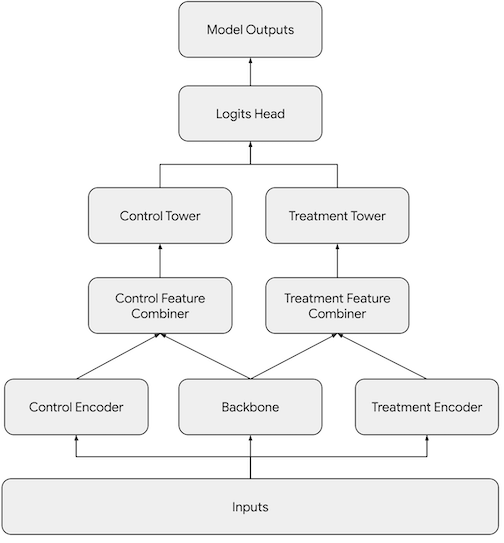

Since we are interested in measuring the increase in probability of a visit occuring from the treatment, we will train an uplift model using the binary crossentropy loss. The treatment and control heads are two seperate classification heads that estimate the probability of a visit occuring with and without the treatment respectively. The uplift is then computed as the difference of the estimated treatment and control visit probabilities.

In [ ]:
FEATURE_NAMES = [f"f{i}" for i in range(12)]
TREATMENT_NAME = "treatment"
LABEL_NAME = "visit"

def preprocess(inputs: dict[str, tf.Tensor]) -> dict[str, tf.Tensor]:
  inputs = tf.nest.map_structure(lambda x: tf.expand_dims(x, axis=-1), inputs)
  features = {name: inputs[name] for name in FEATURE_NAMES}
  features[TREATMENT_NAME] = inputs[TREATMENT_NAME]
  label = tf.cast(inputs[LABEL_NAME], tf.float32)
  return features, label

uplift_network = two_tower_uplift_network.TwoTowerUpliftNetwork(
    backbone=tf.keras.Sequential([
        concat_features.ConcatFeatures(feature_names=FEATURE_NAMES),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dropout(0.1),
    ]),
    control_tower=tf.keras.Sequential([
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dropout(0.1),
    ]),
    treatment_tower=tf.keras.Sequential([
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dropout(0.1),
    ]),
    logits_head=two_tower_logits_head.TwoTowerLogitsHead(
        control_head=tf.keras.layers.Dense(1),
        treatment_head=tf.keras.layers.Dense(1),
    ),
)

uplift_model = two_tower_uplift_model.TwoTowerUpliftModel(
  treatment_indicator_feature_name=TREATMENT_NAME,
  uplift_network=uplift_network,
  inverse_link_fn=tf.math.sigmoid,
)

uplift_model.compile(
  optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.05),
  loss=true_logits_loss.TrueLogitsLoss(
      loss_fn=tf.keras.losses.binary_crossentropy,
      from_logits=True,
  ),
  metrics=[
    treatment_fraction.TreatmentFraction(),
    uplift_mean.UpliftMean(),
    label_mean.LabelMean(),
  ],
)

uplift_model.fit(
    train_dataset.map(preprocess).batch(1024),
    validation_data=test_dataset.map(preprocess).batch(1024),
    epochs=3,
);

Epoch 1/3
12676/12676 [==============================] - 169s 12ms/step - loss: 0.1194 - treatment_fraction: 0.8500 - uplift/mean: 0.0045 - uplift/mean/control: 0.0016 - uplift/mean/treatment: 0.0022 - label/mean: 0.0470 - label/mean/control: 0.0384 - label/mean/treatment: 0.0485 - val_loss: 0.1134 - val_treatment_fraction: 0.8502 - val_uplift/mean: 0.0055 - val_uplift/mean/control: 0.0051 - val_uplift/mean/treatment: 0.0056 - val_label/mean: 0.0467 - val_label/mean/control: 0.0379 - val_label/mean/treatment: 0.0483
Epoch 2/3
12676/12676 [==============================] - 170s 13ms/step - loss: 0.1143 - treatment_fraction: 0.8500 - uplift/mean: 0.0066 - uplift/mean/control: 0.0058 - uplift/mean/treatment: 0.0064 - label/mean: 0.0470 - label/mean/control: 0.0384 - label/mean/treatment: 0.0485 - val_loss: 0.1105 - val_treatment_fraction: 0.8502 - val_uplift/mean: 0.0069 - val_uplift/mean/control: 0.0064 - val_uplift/mean/treatment: 0.0070 - val_label/mean: 0.0467 - val_label/mean/control

# Uplift Evaluation

There are various ways to evaluate uplift models. The *uplift curve* is a powerful visual tool that demonstrates the effectiveness of an uplift model in identifying the right users to target, compared to simply using random selection. While there are different versions of uplift curve, we will focus on the absolute cumulative uplift curve (introduced in Equation 17 of [[3](https://proceedings.mlr.press/v67/gutierrez17a/gutierrez17a.pdf)]) because of its relative simplicity.

As stated before, the goal of an uplift model is to identify the set of users whose likelihood of visiting increases the most when exposed to the treatment. For any number of users *n*, we can estimate the expected number of incremental visits ($\Delta$V) if *n* users were to be treated by:

$$\Delta V(n) =  (\frac{\sum_{i=1}^n{V^T}}{N^T(n)} - \frac{\sum_{i=1}^n{V^C}}{N^C(n)}) \cdot n $$

where $N^T(n)$ is the number of treatment examples amongst the *n* individuals and $N^C(n)$ is the number of control examples amongst the *n* individuals.

To compute the uplift curve we sort the test dataset in descending order of the predicted uplift, and compute the expected number of incremental visits if the top *n* users were to be treated, where *n* ranges from one to the entire test dataset. Since a good uplift model will sort the users with the highest treatment effect first, we would expect the uplift curve to show that the majority of incremental visits can be captured by treating just a small portion of targeted individuals. In particular, we would expect the number of incremental visits to always be greater than the incremental visits gained by random selection (which we can visualize by *not* sorting the test dataset).

In [ ]:
def uplift_curve(visit: np.ndarray, treatment: np.ndarray, uplift: np.ndarray | None = None) -> np.ndarray:
  """Computes the incremental visits by different number of treated individuals."""
  # Sort by the uplift predictions if given. Otherwise the computed uplift curve
  # will be that of a random selection strategy.
  if uplift is not None:
    sorted_indices = np.argsort(uplift)[::-1]
    visit, treatment = visit[sorted_indices], treatment[sorted_indices]

  # Compute the cumulative number of control and treatment visits.
  ctrl_visit, trmt_visit = visit.copy(), visit.copy()
  ctrl_visit[treatment == 1] = 0
  trmt_visit[treatment == 0] = 0
  ctrl_visits = np.cumsum(ctrl_visit)
  trmt_visits = np.cumsum(trmt_visit)

  # Compute the cumulative number of control and treatment individuals.
  num_ctrl = np.cumsum(treatment == 0)
  num_trmt = np.cumsum(treatment == 1)

  # Compute the visit rate for top n individuals, with n ranging from 1 to all.
  avg_ctrl_visits = np.divide(ctrl_visits, num_ctrl, out=np.zeros_like(ctrl_visits, dtype=np.float32), where=num_ctrl > 0)
  avg_trmt_visits = np.divide(trmt_visits, num_trmt, out=np.zeros_like(trmt_visits, dtype=np.float32), where=num_trmt > 0)

  # Estimate the expected number of incremental visits.
  avg_treatment_effect = avg_trmt_visits - avg_ctrl_visits
  expected_incremental_visits = avg_treatment_effect * (num_trmt + num_ctrl)
  return expected_incremental_visits

In [ ]:
# Extract label and treatment indicator from test data.
selector = lambda x: {TREATMENT_NAME: x[TREATMENT_NAME], LABEL_NAME: x[LABEL_NAME]}
test_df = tfds.as_dataframe(test_dataset.map(selector))
visit = test_df[LABEL_NAME].to_numpy().astype(np.int64)
treatment = test_df[TREATMENT_NAME].to_numpy().astype(np.int64)

In [ ]:
# Compute uplift predictions on the test dataset.
predictions = uplift_model.predict(test_dataset.map(preprocess).batch(1024))
uplift_predictions = predictions["uplift_predictions"].squeeze()

977/977 [==============================] - 17s 13ms/step


In [ ]:
# Compute incremental visists for random selection and for uplift targeting.
random_incremental_visits = uplift_curve(visit, treatment)
uplift_incremental_visits = uplift_curve(visit, treatment, uplift_predictions)

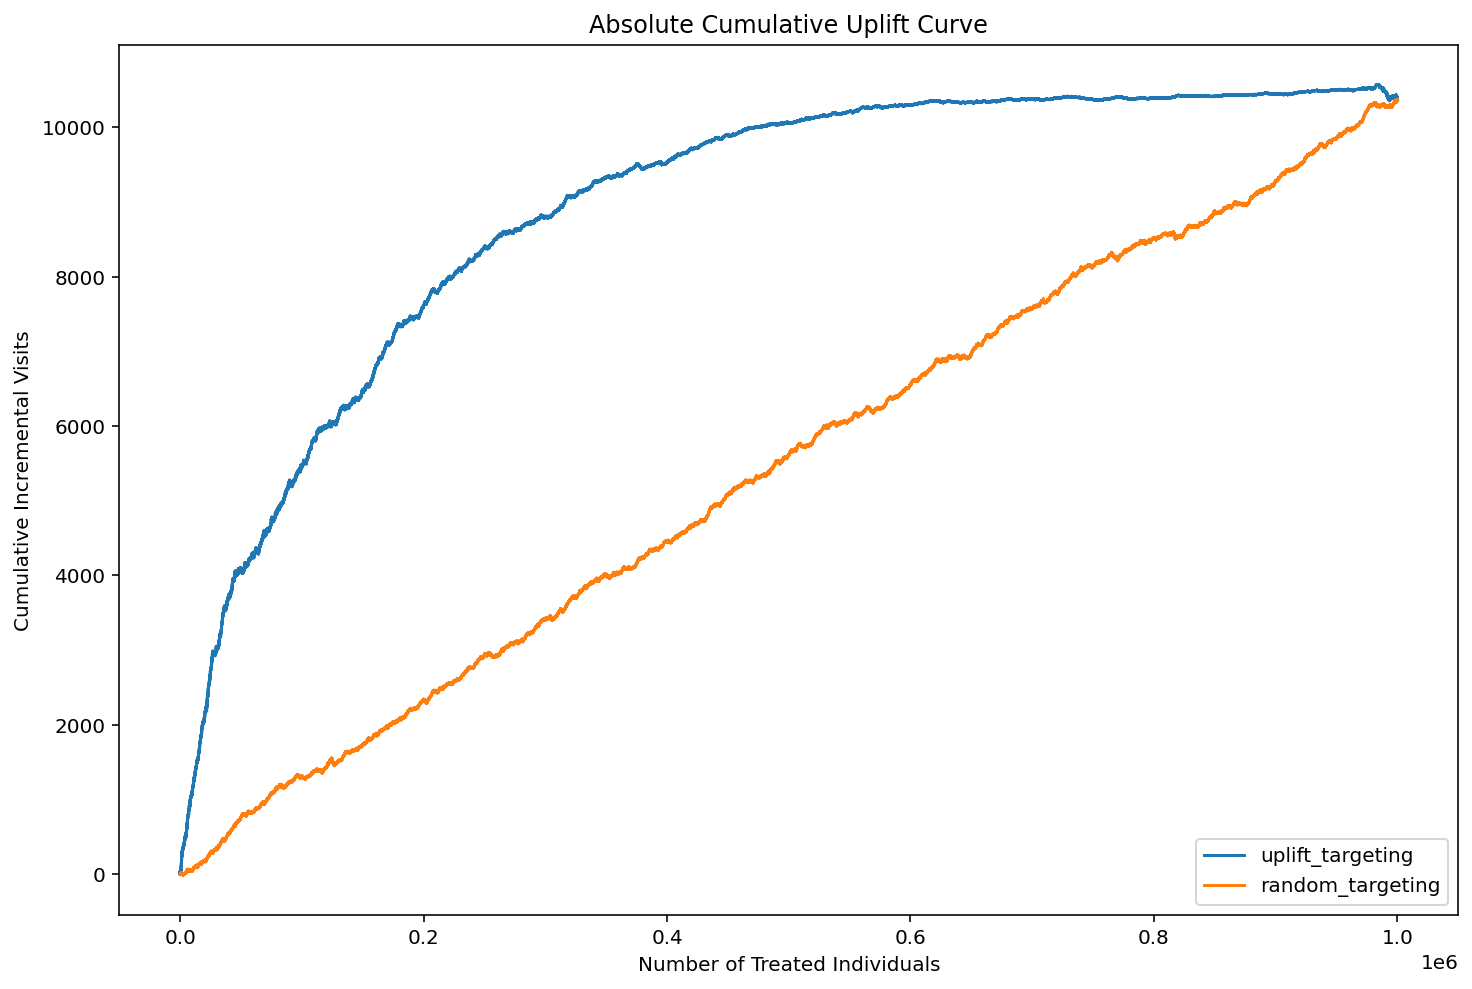

In [ ]:
plt.figure(figsize=(12, 8))
num_individuals = range(len(uplift_predictions))
plt.plot(num_individuals, uplift_incremental_visits, label="uplift_targeting")
plt.plot(num_individuals, random_incremental_visits, label="random_targeting")
plt.title("Absolute Cumulative Uplift Curve")
plt.ylabel("Cumulative Incremental Visits")
plt.xlabel("Number of Treated Individuals")
plt.legend(loc="lower right")
plt.rc('font', size=14)
plt.show()

The uplift curve demonstrates that targeting customers with the uplift model can lead to significantly more visits than random selection. For example, uplift targeting could bring in 5000 extra visits when treating 100k individuals, while random selection would likely yield less than 2000 extra visits.

As mentioned earlier, the uplift curve is just one evaluation method which can also be turned into a more rigurous, quantifiable metric by measuring the area under the uplift curve (AUUC). See this paper [[4](https://arxiv.org/pdf/2002.05897.pdf)] for a more comprehensive overview of the various metrics used in uplift modeling.